
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [137]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures,label_binarize,LabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from plotnine import *
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report,roc_curve,auc,cohen_kappa_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [128]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [129]:
# Converting y into categorical
ha['cp'] = ha['cp'].astype('category')
ha['sex'] = ha['sex'].astype('category')
ha['restecg'] = ha['restecg'].astype('category')
ha['output'] = ha['output'].astype('category')

In [130]:
ha= ha.dropna()
ha.head(1)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1


In [131]:
X = ha.drop(['cp'], axis=1)
y = ha['cp']

In [138]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


## Knn

In [139]:
# CT to preprocess numerical and categorical featers
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

In [140]:
# Create the pipeline
my_pipeline_knn = Pipeline([
    ("standerdize_dummify", ct),
    ("knn", KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': [1, 3, 5, 10, 50, 100] }

grid_search_knn = GridSearchCV(my_pipeline_knn, param_grid_knn, cv=cv, scoring='accuracy') # don't need to cross validate if you do gridsearch
gscv_fitted=grid_search_knn.fit(X, y)

# create a data frame to see which K is the best
dat1 = pd.DataFrame(param_grid_knn)
test_score_1 = grid_search_knn.cv_results_['mean_test_score']
dat1['scores'] = test_score_1
sorted_dat1 = pd.DataFrame(dat1).sort_values('scores', ascending= False)
sorted_dat1


,knn__n_neighbors,scores
3,10,0.538492
4,50,0.535185
5,100,0.516931
2,5,0.509127
1,3,0.479630
0,1,0.443386


In [145]:
my_pipeline_knn = Pipeline([
    ("standerdize_dummify", ct),
    ("knn", KNeighborsClassifier(n_neighbors=10))
])

In [146]:

# Fit the pipeline on the training data
my_pipeline_knn.fit(X, y)
y_pred_knn = my_pipeline_knn.predict(X)

In [147]:
conf_matrix_knn = confusion_matrix(y, y_pred_knn)
pd.DataFrame(conf_matrix_knn)
# actual is vertical
# predicted is horizontal

,0,1,2,3
0,109,5,13,1
1,11,13,19,1
2,33,6,42,0
3,11,2,7,0


In [144]:
recall_scores_knn = pd.DataFrame(classification_report(y, y_pred_knn, output_dict=True)).transpose()
recall_scores_knn

,precision,recall,f1-score,support
0,0.562814,0.875000,0.685015,128.00000
1,0.000000,0.000000,0.000000,44.00000
2,0.418919,0.382716,0.400000,81.00000
3,0.000000,0.000000,0.000000,20.00000
accuracy,0.523810,0.523810,0.523810,0.52381
macro avg,0.245433,0.314429,0.271254,273.00000
weighted avg,0.388178,0.523810,0.439861,273.00000


## Descion Tree

In [154]:
my_pipeline_dt = Pipeline([
    ("standerdize_dummify", ct),
    ("decision_tree", DecisionTreeClassifier(max_depth=3)) # You can adjust max_depth as needed
])

param_grid = {'decision_tree__max_depth': [1, 3, 6, 9, 12, 15] }

grid_search_dt = GridSearchCV(my_pipeline_dt, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
gscv_fitted_dt = grid_search_dt.fit(X, y)

# Extracting the scores and parameters from the results
mean_test_scores_dt = gscv_fitted_dt.cv_results_['mean_test_score']
max_depths = [param['decision_tree__max_depth'] for param in gscv_fitted_dt.cv_results_['params']]
pd.DataFrame({"max_depths": max_depths, "accuracy": mean_test_scores_dt}).sort_values(by='accuracy', ascending=False)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


,max_depths,accuracy
0,1,0.574735
1,3,0.505159
2,6,0.501587
4,12,0.453836
5,15,0.443254
3,9,0.435582


In [155]:
my_pipeline_dt = Pipeline([
    ("standerdize_dummify", ct),
    ("decision_tree", DecisionTreeClassifier(max_depth=1)) # You can adjust max_depth as needed
])


In [156]:
# Fit the pipeline on the training data
my_pipeline_dt.fit(X,y)
y_pred_dt= my_pipeline_dt.predict(X)

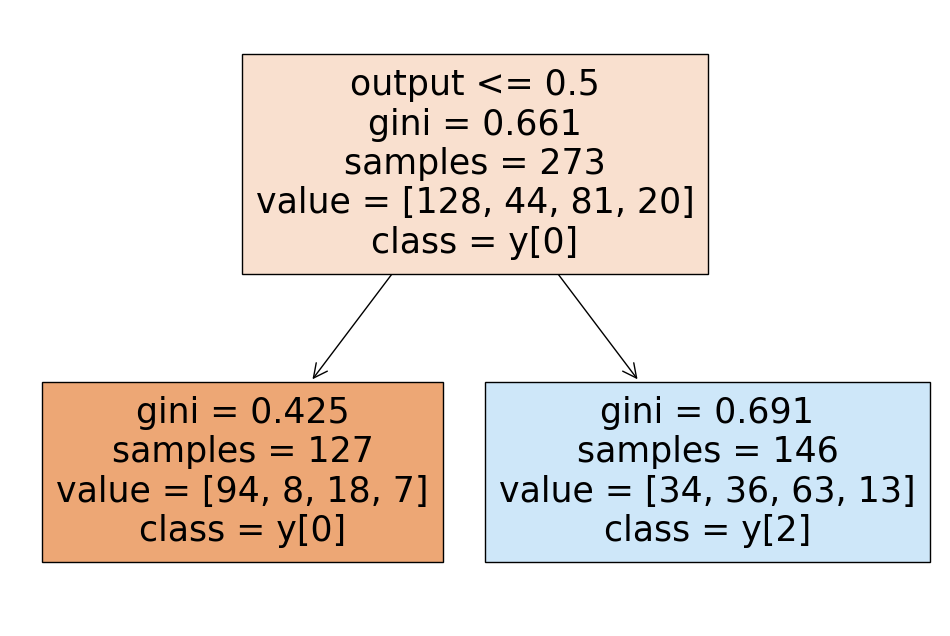

In [157]:
decision_tree_model = my_pipeline_dt.named_steps['decision_tree']

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_model, filled=True, feature_names=X.columns, class_names=True)
plt.show()

# output is not categorical

In [158]:
conf_matrix = confusion_matrix(y, y_pred_dt)
pd.DataFrame(conf_matrix)

,0,1,2,3
0,94,0,34,0
1,8,0,36,0
2,18,0,63,0
3,7,0,13,0


In [159]:
recall_scores_dt = pd.DataFrame(classification_report(y, y_pred_dt, output_dict=True)).transpose()
recall_scores_dt

,precision,recall,f1-score,support
0,0.740157,0.734375,0.737255,128.000000
1,0.000000,0.000000,0.000000,44.000000
2,0.431507,0.777778,0.555066,81.000000
3,0.000000,0.000000,0.000000,20.000000
accuracy,0.575092,0.575092,0.575092,0.575092
macro avg,0.292916,0.378038,0.323080,273.000000
weighted avg,0.475063,0.575092,0.510363,273.000000


## LDA

In [160]:
lda_pipeline = Pipeline([
    ("standerdize_dummify", ct),
    ("lda", LinearDiscriminantAnalysis())
])
lda_pipeline.fit(X, y)
y_pred_lda = lda_pipeline.predict(X)

In [161]:
conf_matrix_lda = confusion_matrix(y, y_pred_lda)
pd.DataFrame(conf_matrix_lda)

,0,1,2,3
0,98,2,27,1
1,8,2,32,2
2,21,5,55,0
3,7,0,11,2


In [162]:
recall_scores_lda = pd.DataFrame(classification_report(y, y_pred_lda, output_dict=True)).transpose()
recall_scores_lda

,precision,recall,f1-score,support
0,0.731343,0.765625,0.748092,128.000000
1,0.222222,0.045455,0.075472,44.000000
2,0.440000,0.679012,0.533981,81.000000
3,0.400000,0.100000,0.160000,20.000000
accuracy,0.575092,0.575092,0.575092,0.575092
macro avg,0.448391,0.397523,0.379386,273.000000
weighted avg,0.538570,0.575092,0.533073,273.000000


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [188]:
ha['cp_is_0'] = (ha['cp'] == 0)
ha['cp_is_1'] = (ha['cp'] == 1)
ha['cp_is_2'] = (ha['cp'] == 2)
ha['cp_is_3'] = (ha['cp'] == 3)
ha.head(1)

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_0,cp_is_1,cp_is_2,cp_is_3
0,63,1,3,145,233,0,150,1,False,False,False,True


### **1. cp_is_0**

In [191]:
X = ha.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)
y= ha['cp_is_0']

In [192]:
# Create the pipeline
pipeline_0 = Pipeline([
    ("standardize_dummify", ct),
    ("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))
])

In [195]:
#tuning using grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(pipeline_0, params, cv = cv, scoring='f1')
gscv_fitted = gscv.fit(X, y)

In [194]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logreg__C']
alphas = gscv_fitted.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambdas": lambdas,"alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores.head()

,lambdas,alphas,f1_score
22,0.1,0.8,0.727824
24,1,0.1,0.725294
25,1,0.2,0.725294
26,1,0.4,0.725294
28,1,0.8,0.723290


### **2. cp_is_1**

In [196]:
y= ha['cp_is_1']

In [197]:
# Create the pipeline
pipeline_1 = Pipeline([
    ("standardize_dummify", ct),
    ("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))
])

In [198]:
#tuning using grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(pipeline_1, params, cv = cv, scoring='f1')
gscv_fitted = gscv.fit(X, y)

In [199]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logreg__C']
alphas = gscv_fitted.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambdas": lambdas,"alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores.head()

,lambdas,alphas,f1_score
0,0.0001,0.1,0.0
1,0.0001,0.2,0.0
20,0.1,0.4,0.0
21,0.1,0.6,0.0
22,0.1,0.8,0.0


### **3. cp_is_2**

In [200]:
y= ha['cp_is_2']

In [201]:
# Create the pipeline
pipeline_2 = Pipeline([
    ("standardize_dummify", ct),
    ("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))
])

In [202]:
#tuning using grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(pipeline_2, params, cv = cv, scoring='f1')
gscv_fitted = gscv.fit(X, y)

In [203]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logreg__C']
alphas = gscv_fitted.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambdas": lambdas,"alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores.head()

,lambdas,alphas,f1_score
35,10,0.9,0.136768
34,10,0.8,0.136768
33,10,0.6,0.136768
32,10,0.4,0.136768
31,10,0.2,0.136768


### **4. cp_is_3**

In [204]:
X = ha.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)
y= ha['cp_is_3']

In [205]:
# Create the pipeline
pipeline_3 = Pipeline([
    ("standardize_dummify", ct),
    ("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))
])

In [206]:
#tuning using grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(pipeline_3, params, cv = cv, scoring='f1')
gscv_fitted = gscv.fit(X, y)

In [207]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logreg__C']
alphas = gscv_fitted.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambdas": lambdas,"alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores.head()

,lambdas,alphas,f1_score
0,0.0001,0.1,0.0
1,0.0001,0.2,0.0
20,0.1,0.4,0.0
21,0.1,0.6,0.0
22,0.1,0.8,0.0


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

### 0 and 1

In [218]:
ha_0_1 = ha[(ha['cp'] == 0) | (ha['cp'] == 1)]
ha_0_1 = ha_0_1.drop(["cp_is_3","cp_is_2","cp_is_1","cp_is_0"], axis = 1)

X = ha_0_1.drop(['cp'], axis = 1)
y = ha_0_1["cp"]

In [219]:
# Create the pipeline
pipeline_1 = Pipeline([
    ("standardize_dummify", ct),
    ("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))
])

In [220]:
#tuning using grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(pipeline_1, params, cv = cv, scoring='roc_auc_ovo')
gscv_fitted = gscv.fit(X, y)

In [221]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logreg__C']
alphas = gscv_fitted.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambdas": lambdas,"alphas": alphas, "roc_auc_ovo": mean_test_scores}).sort_values(by='roc_auc_ovo', ascending=False)
model_scores.head()

,lambdas,alphas,roc_auc_ovo
21,0.1,0.6,0.835962
23,0.1,0.9,0.835833
22,0.1,0.8,0.835256
19,0.1,0.2,0.834359
20,0.1,0.4,0.832692


### 0 and 2

In [222]:
ha_0_2 = ha[(ha['cp'] == 0) | (ha['cp'] == 2)]
ha_0_2 = ha_0_2.drop(["cp_is_3","cp_is_2","cp_is_1","cp_is_0"], axis = 1)

X = ha_0_2.drop(['cp'], axis = 1)
y = ha_0_2["cp"]

In [223]:
# Create the pipeline
pipeline_2 = Pipeline([
    ("standardize_dummify", ct),
    ("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))
])

In [224]:
#tuning using grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(pipeline_2, params, cv = cv, scoring='roc_auc_ovo')
gscv_fitted = gscv.fit(X, y)

In [225]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logreg__C']
alphas = gscv_fitted.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambdas": lambdas,"alphas": alphas, "roc_auc_ovo": mean_test_scores}).sort_values(by='roc_auc_ovo', ascending=False)
model_scores.head()

,lambdas,alphas,roc_auc_ovo
23,0.1,0.9,0.783560
22,0.1,0.8,0.780996
21,0.1,0.6,0.776549
29,1,0.9,0.762598
20,0.1,0.4,0.762242


### 0 and 3

In [226]:
ha_0_3 = ha[(ha['cp'] == 0) | (ha['cp'] == 3)]
ha_0_3 = ha_0_3.drop(["cp_is_3","cp_is_2","cp_is_1","cp_is_0"], axis = 1)

X = ha_0_3.drop(['cp'], axis = 1)
y = ha_0_3["cp"]

In [227]:
# Create the pipeline
pipeline_3 = Pipeline([
    ("standardize_dummify", ct),
    ("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))
])

In [228]:
#tuning using grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(pipeline_3, params, cv = cv, scoring='roc_auc_ovo')
gscv_fitted = gscv.fit(X, y)

In [229]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logreg__C']
alphas = gscv_fitted.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambdas": lambdas,"alphas": alphas, "roc_auc_ovo": mean_test_scores}).sort_values(by='roc_auc_ovo', ascending=False)
model_scores.head()

,lambdas,alphas,roc_auc_ovo
19,0.1,0.2,0.760897
31,10,0.2,0.757051
30,10,0.1,0.757051
25,1,0.2,0.757051
24,1,0.1,0.757051
